In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
#importing the dataset
with open('/content/content.json') as content:
  data1 = json.load(content)

In [3]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [4]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [5]:
#printing the data
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,"hi, is this is the pirate's organization",greeting
4,any pirates here ?,greeting
...,...,...
76,tell me more about the pre requisites,prerequisites
77,give more details about the pre-requisites,prerequisites
78,What are the requirements,prerequisites
79,what's the basic requirements,prerequisites


In [6]:
data = data.sample(frac=1)

In [7]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
57,how to get recruited,join
23,i will catch you later,goodbye
7,hey,greeting
21,goodbye,goodbye
62,how to join the straw hat pirates,join
...,...,...
70,where can i find the strawhat center,whereisthecenter
52,which place do you live in,whereareyou
39,what are you,whoareyou
13,knock knock,greeting


In [8]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [9]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [10]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  96
output length:  8


In [11]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [12]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [13]:
#training the model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
3/3 [==============================] - 3s 7ms/step - loss: 2.0820 - accuracy: 0.0988
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0784 - accuracy: 0.2346
Epoch 3/200
3/3 [==============================] - 0s 9ms/step - loss: 2.0752 - accuracy: 0.2346
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0724 - accuracy: 0.2346
Epoch 5/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0691 - accuracy: 0.2222
Epoch 6/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0661 - accuracy: 0.2099
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 2.0626 - accuracy: 0.2099
Epoch 8/200
3/3 [==============================] - 0s 9ms/step - loss: 2.0587 - accuracy: 0.2099
Epoch 9/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0545 - accuracy: 0.2099
Epoch 10/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0498 - accuracy: 0.2099
Epoch 11/200
3/3 [===========

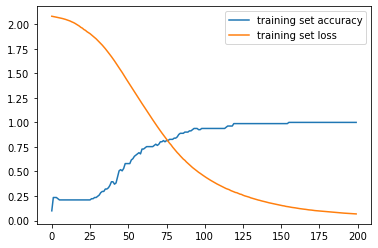

In [14]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [15]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You : hi there
Going Merry :  Hi. Welcome to the world's largest pirate organization - The Strawhats
You : How do I join the pirates?
Going Merry :  you need to contact the nearest straw hats center once you have completed the pre-requisites
You : what are the pre-requisites?
Going Merry :  swordsman, a medical reindeer, taekwando Cook, master navigator, simple minded monkey, highly intelligent strategist, god usop. you gotta be one of these things to pass the requirement and join the pirates
You : what are the pre requisites?
Going Merry :  swordsman, a medical reindeer, taekwando Cook, master navigator, simple minded monkey, highly intelligent strategist, god usop. you gotta be one of these things to pass the requirement and join the pirates
You : alright , who are you 
Going Merry :  Going Merry at your service
You : how are you
Going Merry :  Things are Great
You : thanks
Going Merry :  Yeah Sure, Will talk to you later
